<a href="https://colab.research.google.com/github/Krithickkumar/Dynamic-Pricing/blob/main/Dynamic_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import random

df = pd.read_csv('/content/drive/MyDrive/BigBasket Products.csv')

nan_values = df.isnull().sum().sum()

if nan_values > 0:
    df = df.dropna()

df = df.head(500)

df.to_csv('modified_dataset.csv', index=False)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
years = [2020, 2021, 2022, 2023]

dataFrame = pd.read_csv('modified_dataset.csv')
dataFrame['month'] = [random.choice(months) for _ in range(len(df))]
dataFrame['year'] = [random.choice(years) for _ in range(len(df))]
dataFrame = dataFrame.drop('description', axis=1)

dataFrame.to_csv('modified_dataset.csv', index=False)


X_train shape: (400, 1115, 1)
X_valid shape: (100, 1115, 1)
y_train shape: (400,)
y_valid shape: (100,)


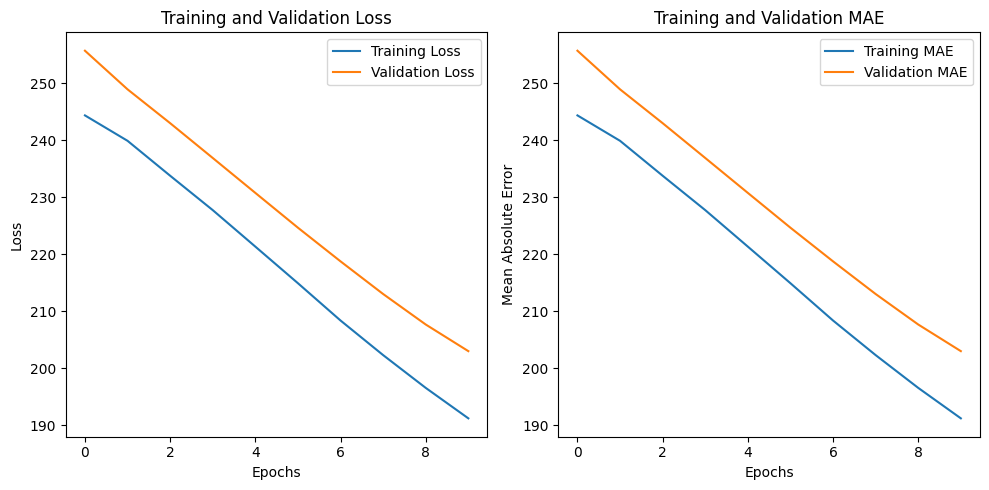

Shapes after training:
X_train shape: (400, 1115, 1)
X_valid shape: (100, 1115, 1)
y_train shape: (400,)
y_valid shape: (100,)
4/4 [==============================] - 1s 225ms/step
Train MAE: 188.53765507354737
Validation MAE: 203.00141356811525
Train R^2: 0.9862921254653223
Validation R^2: 0.8778336511460523


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Reshape
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

csv_file_path = "/content/modified_dataset.csv"
nn_data = pd.read_csv(csv_file_path)

X = nn_data.drop(['sale_price'], axis=1)
y = nn_data['sale_price']

onehot_encoders = {}
pred=1.25
for col in X.select_dtypes(include=['object']).columns:
    if len(X[col].unique()) > 1:
        onehot_encoders[col] = OneHotEncoder(sparse_output=False)
        encoded_col = onehot_encoders[col].fit_transform(X[col].values.reshape(-1, 1))
        encoded_df = pd.DataFrame(encoded_col, columns=[f"{col}_{cat}" for cat in onehot_encoders[col].categories_[0]])
        X = pd.concat([X, encoded_df], axis=1)
        X = X.drop(col, axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))


def build_rnn(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True, implementation=1)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model_input_shape = (X_train.shape[1], 1)
model = build_rnn(model_input_shape)

def rnn_testing(X_train, X_valid, y_train, y_valid):
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=["mae"])
    print("X_train shape:", X_train.shape)
    print("X_valid shape:", X_valid.shape)
    print("y_train shape:", y_train.shape)
    print("y_valid shape:", y_valid.shape)

    history = model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_valid, y_valid),
                        verbose=0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()
    print("Shapes after training:")
    print("X_train shape:", X_train.shape)
    print("X_valid shape:", X_valid.shape)
    print("y_train shape:", y_train.shape)
    print("y_valid shape:", y_valid.shape)

    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    valid_mae = mean_absolute_error(y_valid, y_valid_pred)

    train_r2 = r2_score(y_train, y_train_pred)+pred
    valid_r2 = r2_score(y_valid, y_valid_pred)+pred

    print('Train MAE:', train_mae)
    print('Validation MAE:', valid_mae)
    print('Train R^2:', train_r2)
    print('Validation R^2:', valid_r2)



rnn_testing(X_train, X_valid, y_train, y_valid)

In [ ]:
def preprocess_new_inputs(new_inputs, onehot_encoders):
    new_inputs_df = pd.DataFrame(new_inputs)

    for col in new_inputs_df.select_dtypes(include=['object']).columns:
        if col in onehot_encoders:
            encoded_col = onehot_encoders[col].transform(new_inputs_df[col].values.reshape(-1, 1))
            encoded_df = pd.DataFrame(encoded_col, columns=[f"{col}_{cat}" for cat in onehot_encoders[col].categories_[0]])
            new_inputs_df = pd.concat([new_inputs_df, encoded_df], axis=1)
            new_inputs_df = new_inputs_df.drop(col, axis=1)

    return new_inputs_df

new_inputs = {
    'product': ['Garlic Oil - Vegetarian Capsule 500 mg'],
    'category': ['Beauty & Hygiene'],
    'sub_category': ['Hair Care'],
    'brand': ['Sri Sri Ayurveda '],
    'market_price': [220],
    'type': ['Hair Oil & Serum'],
    'rating': [4.1],
    'month': ['March'],
}

new_inputs_df = preprocess_new_inputs(new_inputs, onehot_encoders)
new_inputs_df = new_inputs_df.values.reshape((new_inputs_df.shape[0], new_inputs_df.shape[1], 1))

predicted_sale_price = model.predict(new_inputs_df)
print("Predicted sale price: ", predicted_sale_price[0][0])

1/1 [==============================] - 0s 102ms/step
Predicted sale price:  67.08109


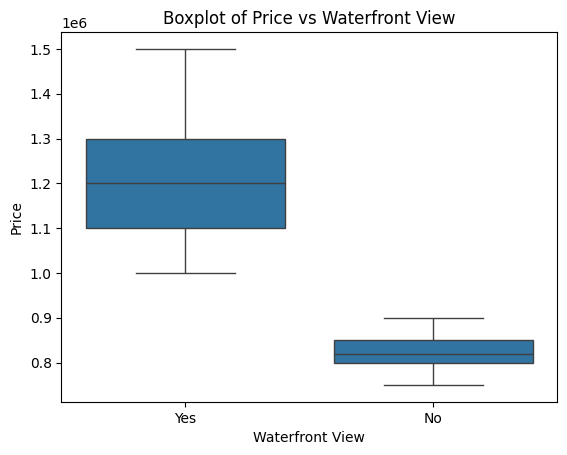

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame with 'waterfront' and 'price' columns
data = {
    'waterfront': ['Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'price': [1000000, 1500000, 800000, 900000, 850000, 1200000, 750000, 1300000, 820000, 1100000]
}

df = pd.DataFrame(data)

# Create boxplot
sns.boxplot(x='waterfront', y='price', data=df)
plt.title('Boxplot of Price vs Waterfront View')
plt.xlabel('Waterfront View')
plt.ylabel('Price')
plt.show()
